In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Загружаем данные

In [3]:
users_data = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/4qY27tJ23G_B1g')
orders = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prdO8FDQx7lzCg')
products = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/atwrlmB_wu-fHA')

## Пользователи

In [4]:
users_data.head(10)

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
5,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0
6,969,1262,create_order,2022-08-26 00:06:25.000000,2022-08-26,0
7,970,1263,create_order,2022-08-26 00:08:22.000000,2022-08-26,1
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0
9,971,1264,create_order,2022-08-26 00:10:53.000000,2022-08-26,1


In [5]:
users_data.dtypes

user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

In [6]:
# приводим колонки с датой к типу даты
users_data[['time', 'date']] = users_data[['time', 'date']].apply(lambda x: pd.to_datetime(x))

In [7]:
# смотрим, есть ли незаполненные ячейки
users_data.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [8]:
# смотрим, какие есть статусы
users_data.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

In [9]:
# проверим, может ли один и тот же заказ значиться дважды с разными статусами
canceled_orders = users_data.query('action == "cancel_order"').order_id.to_list()
users_data.query('(order_id.isin(@canceled_orders)) and (action == "create_order")').order_id.nunique()

214

In [10]:
len(canceled_orders)

214

!!! Получается, что один и тот же заказ встречается с разными статусами

In [11]:
# оценивае количество заказов в каждой группе
users_data.group.value_counts()

1    2646
0    1691
Name: group, dtype: int64

## Заказы

In [12]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [13]:
orders.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

In [14]:
# приводим дату к типу даты
orders['creation_time'] = pd.to_datetime(orders.creation_time)

In [15]:
# смотрим, за какой период у нас есть наблюдения
orders.creation_time.min()

Timestamp('2022-08-26 00:00:19')

In [16]:
orders.creation_time.max()

Timestamp('2022-09-08 23:41:24')

In [17]:
# смотрим, есть ли незаполненные ячейки
orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

## Продукты

In [18]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


# Рассчитаем стоимость каждого заказа

Для начала создадим новый датафрейм и преобразуем данные в столбце product_ids таблицы orders в список

In [19]:
orders

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"
...,...,...,...
4118,59422,2022-09-08 23:13:03,"{84, 8, 24}"
4119,59439,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}"
4120,59464,2022-09-08 23:22:27,"{60, 41, 46}"
4121,59487,2022-09-08 23:29:06,"{9, 62, 77}"


In [20]:
df = orders
# убираем фигурные скобки, преобразуем product_ids в список
df['product_ids'] = df['product_ids'].apply(lambda x: x.strip('{}').split(','))

In [21]:
# раскроем список из колонки продуктов и переименуем эту колонку
df = df.explode(column = 'product_ids').rename(columns = {'product_ids': 'product_id'})
df.head()

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19,75
0,1255,2022-08-26 00:00:19,22
0,1255,2022-08-26 00:00:19,53
0,1255,2022-08-26 00:00:19,84
1,1256,2022-08-26 00:02:21,56


In [22]:
df['product_id'] = df.product_id.astype('int')

In [23]:
# добавим цену из таблицы products
df = df.merge(products[['product_id', 'price']], how = 'left', on = 'product_id')
# проыерим, всем ли продуктам проставилась цена
df.isna().sum()

order_id         0
creation_time    0
product_id       0
price            0
dtype: int64

In [24]:
# рассчитаем стоимость каждого заказа
order_prices = df.groupby('order_id').agg(order_price = ('price', 'sum'))
order_prices

,order_price
order_id,
1255,408.7
1256,250.5
1257,310.2
1258,85.0
1259,228.0
...,...
59422,241.2
59439,518.5
59464,185.9


# Собираем таблицу, которую будем использовать для последующего анализа

Формируем итоговый датасет, в котором для каждого пользователя три показателя: количество покупок и общая сумма покупок за период наблюдения и средний чек. Строго говоря, показатель средний чек не обязательный, так как полностью определяется первыми двумя показателями, но оставим его для удобства восприятия.

In [25]:
sf_df = users_data.merge(order_prices, how = 'left', on = 'order_id')
sf_df.sort_values('order_id').head(20)

,user_id,order_id,action,time,date,group,order_price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,408.7
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,250.5
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,310.2
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,85.0
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,85.0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,228.0
5,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,430.7
6,969,1262,create_order,2022-08-26 00:06:25.000000,2022-08-26,0,358.6
7,970,1263,create_order,2022-08-26 00:08:22.000000,2022-08-26,1,180.3
9,971,1264,create_order,2022-08-26 00:10:53.000000,2022-08-26,1,310.3


In [26]:
# Проверяем, есть ли пропуски
sf_df.isna().sum()

user_id        0
order_id       0
action         0
time           0
date           0
group          0
order_price    0
dtype: int64

In [27]:
# анализируем отмененные заказы 
sf_df.shape[0] - sf_df.query('order_id != @canceled_orders').shape[0]

428

Выше мы посчитали, что у нас было 214 отмененных заказа, но поскольку каждый такой заказ значится дважды (со статусами 'canceled_order' и 'create_order'), то мы получили цифру 428. Из дальнейшего анализа мы эти отмененные заказы исключим

In [28]:
# агрегируем количество заказов и сумму покупок
f_df = sf_df.query('order_id != @canceled_orders')\
            .groupby('user_id', as_index = False)\
            .agg(num_orders = ('order_id', 'nunique'), \
                 total_bill = ('order_price', 'sum'), \
                 group = ('group', 'max'))

# считаем средний чек для каждого пользователя
f_df['avg_bill'] = (f_df.total_bill / f_df.num_orders).round(1)

# для удобства заменим номер группы на ее текстовое название
f_df['group'] = f_df.group.apply(lambda x: 'new' if x ==1 else 'old')

Итоговый датасет выглядит следующим образом

In [29]:
f_df.head()

,user_id,num_orders,total_bill,group,avg_bill
0,964,2,718.9,old,359.5
1,965,9,4155.5,new,461.7
2,967,5,1137.4,new,227.5
3,968,3,1590.7,old,530.2
4,969,2,681.9,old,341.0


# Визуализируем данные

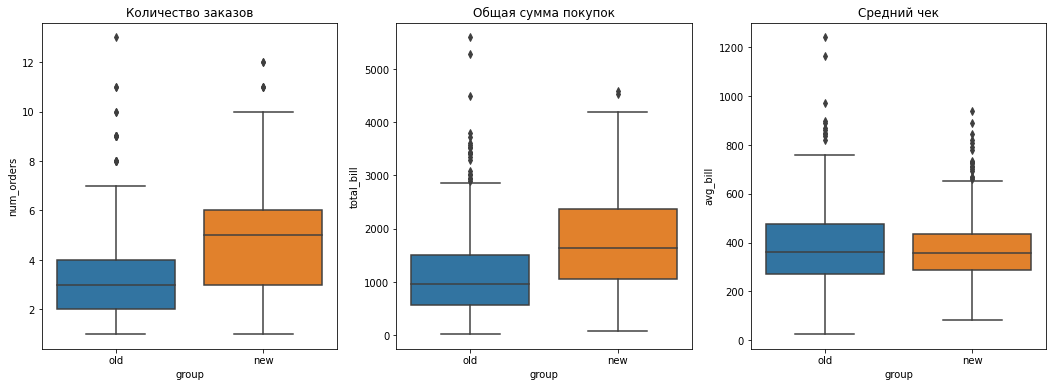

In [30]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))
axes[0].set_title('Количество заказов')
axes[1].set_title('Общая сумма покупок')
axes[2].set_title('Средний чек')
sns.boxplot(ax = axes[0], data = f_df, x = 'group', y = 'num_orders')
sns.boxplot(ax = axes[1], data = f_df, x = 'group', y = 'total_bill')
sns.boxplot(ax = axes[2], data = f_df, x = 'group', y = 'avg_bill')
plt.show()

# Выбираем метод статистического анализа

Поскольку группы у нас две, выбираем между параметрическим t-тестом, непараметрическим критерием Манна-Уитней и бутстрепом

In [31]:
# формируем группы
num_orders_old = f_df.query('group == "old"').num_orders
num_orders_new = f_df.query('group == "new"').num_orders
total_bill_old = f_df.query('group == "old"').total_bill
total_bill_new = f_df.query('group == "new"').total_bill
avg_bill_old = f_df.query('group == "old"').avg_bill
avg_bill_new = f_df.query('group == "new"').avg_bill
groups = [num_orders_old, num_orders_new, total_bill_old, total_bill_new, avg_bill_old, avg_bill_new]

In [32]:
groups_names = ['num_orders_old', 'num_orders_new', 'total_bill_old', 'total_bill_new', 'avg_bill_old', 'avg_bill_new']

Проверим распределение данных

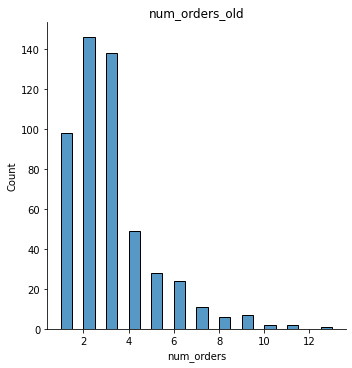

Уровень значимости критерия Шапиро-Уилка для num_orders равен 4.7134366511752175e-23
Распределение данных в группе num_orders отличается от нормального


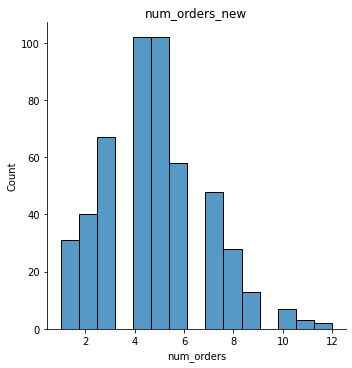

Уровень значимости критерия Шапиро-Уилка для num_orders равен 7.850973204881484e-10
Распределение данных в группе num_orders отличается от нормального


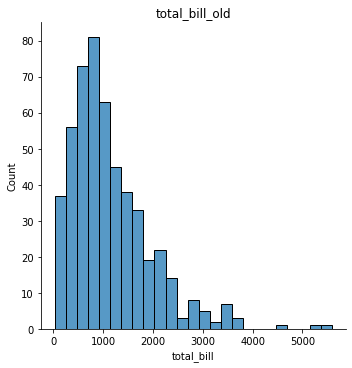

Уровень значимости критерия Шапиро-Уилка для total_bill равен 8.713836969217895e-19
Распределение данных в группе total_bill отличается от нормального


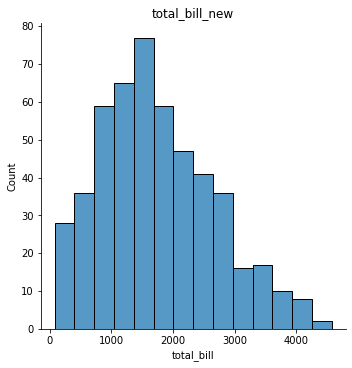

Уровень значимости критерия Шапиро-Уилка для total_bill равен 1.408598961916141e-07
Распределение данных в группе total_bill отличается от нормального


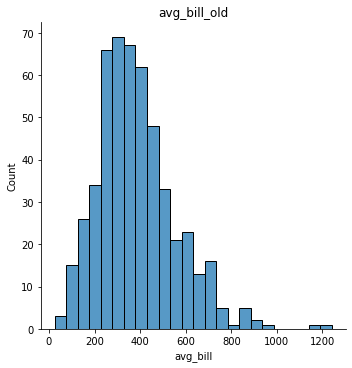

Уровень значимости критерия Шапиро-Уилка для avg_bill равен 2.5542160400626734e-11
Распределение данных в группе avg_bill отличается от нормального


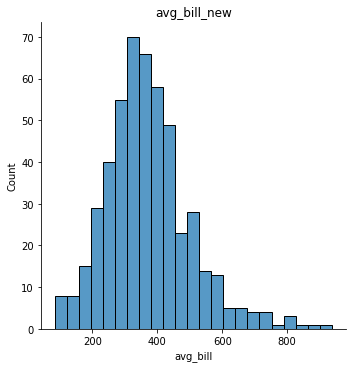

Уровень значимости критерия Шапиро-Уилка для avg_bill равен 2.089729778109728e-10
Распределение данных в группе avg_bill отличается от нормального


In [33]:
i = 0
for gr in groups:
    sns.displot(gr)
    plt.title(groups_names[i])
    plt.show()
    sw = stats.shapiro(gr)[1]
    print(f'Уровень значимости критерия Шапиро-Уилка для {gr.name} равен {sw}')
    if sw < 0.05:
        print(f'Распределение данных в группе {gr.name} отличается от нормального')
    else:
        print(f'Распределение данных в группе {gr.name} является нормальным')
    i += 1

ВЫВОД: распределения во всех исследуемых группах отличается от нормального, но в целом распределения выглядят не плохо и кажется что можно применять t -тест, который, строго говоря, не требует того, чтобы данные были распределены нормально, но требует достаточно больших выборок (чтобы работала ЦПТ) и отстутствия сильных выбросов в данных. Оба условия выполняются.

Для того, чтобы определиться с вариантом теста, проверим, равны ли дисперсии в сравниваемых группах

Для количества заказов

In [239]:
print(f'Уровень значимости криерия Левена равен {stats.levene(num_orders_old, num_orders_new)[1]}')
if stats.levene(num_orders_old, num_orders_new)[1] < 0.05:
      print('Дисперсии НЕ равны')
else:
      print('Дисперсии равны')

Уровень значимости криерия Левена равен 3.654438888775981e-05
Дисперсии НЕ равны


Для общей суммы заказов

In [240]:
print(f'Уровень значимости криерия Левена равен {stats.levene(total_bill_old, total_bill_new)[1]}')
if stats.levene(total_bill_old, total_bill_new)[1] < 0.05:
      print('Дисперсии НЕ равны')
else:
      print('Дисперсии равны')

Уровень значимости криерия Левена равен 1.896012459520485e-05
Дисперсии НЕ равны


Для среднего чека

In [241]:
print(f'Уровень значимости криерия Левена равен {stats.levene(avg_bill_old, avg_bill_new)[1]}')
if stats.levene(avg_bill_old, avg_bill_new)[1] < 0.05:
      print('Дисперсии НЕ равны')
else:
      print('Дисперсии равны')

Уровень значимости криерия Левена равен 2.652857267040283e-07
Дисперсии НЕ равны


ВЫВОД: будем использовать двувыборочный t-критерий для НЕ равных дисперсий

# Проводим t-тест

Для количества заказов

In [242]:
tt_num_orders = stats.ttest_ind(num_orders_old, num_orders_new, equal_var=False)
print(f'Уровень значимости t-критерия равен {tt_num_orders[1]}')
if tt_num_orders[1] < 0.05:
      print('Обнаружены достоверные различия')
else:
      print('Достоверные различия НЕ обнаружены')

Уровень значимости t-критерия равен 1.2374101233656574e-40
Обнаружены достоверные различия


Для общей суммы заказоа

In [243]:
tt_total_bill = stats.ttest_ind(total_bill_old, total_bill_new, equal_var=False)
print(f'Уровень значимости t-критерия равен {tt_total_bill[1]}')
if tt_total_bill[1] < 0.05:
      print('Обнаружены достоверные различия')
else:
      print('Достоверные различия НЕ обнаружены')

Уровень значимости t-критерия равен 1.572166429481266e-27
Обнаружены достоверные различия


In [244]:
tt_avg_bill = stats.ttest_ind(avg_bill_old, avg_bill_new, equal_var=False)
print(f'Уровень значимости t-критерия равен {tt_avg_bill[1]}')
if tt_avg_bill[1] < 0.05:
      print('Обнаружены достоверные различия')
else:
      print('Достоверные различия НЕ обнаружены')

Уровень значимости t-критерия равен 0.1226413312221358
Достоверные различия НЕ обнаружены


Еще раз посмотрим на графики в контексте результатов t-теста

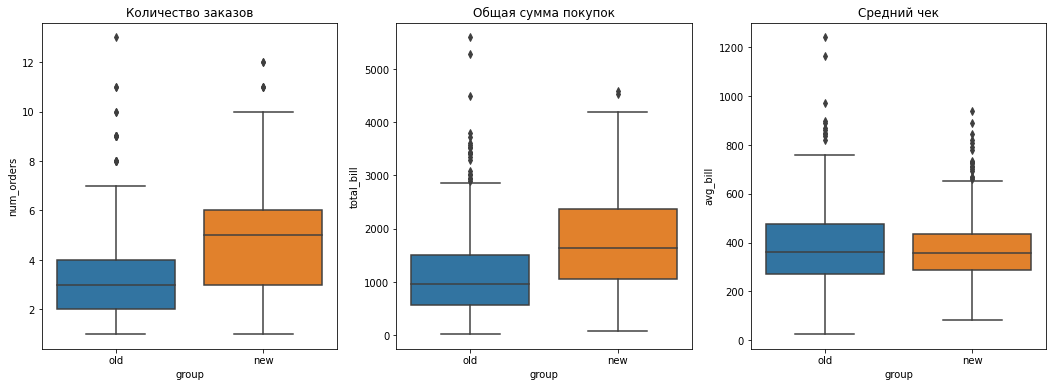

In [245]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))
axes[0].set_title('Количество заказов')
axes[1].set_title('Общая сумма покупок')
axes[2].set_title('Средний чек')
sns.boxplot(ax = axes[0], data = f_df, x = 'group', y = 'num_orders')
sns.boxplot(ax = axes[1], data = f_df, x = 'group', y = 'total_bill')
sns.boxplot(ax = axes[2], data = f_df, x = 'group', y = 'avg_bill')
plt.show()

# Формируем итоговый датасет

In [246]:
#  формируем табличку с описательными характеристиками групп
descr_char = f_df.groupby(['group']).agg(users_number = ('user_id', 'count'), \
                            num_orders = ('num_orders', 'mean'), \
                            avg_bill = ('avg_bill', 'mean'), \
                            total_bill = ('total_bill', 'mean'))\
                        .T.reset_index()
descr_char = descr_char.rename(columns = {'index': 'characteristic', 'new': 'new_mean', 'old': 'old_mean'}).set_index('characteristic')
descr_char

group,new_mean,old_mean
characteristic,,
users_number,501.000000,512.000000
num_orders,4.754491,2.982422
avg_bill,371.202395,386.037891
total_bill,1753.749301,1139.562305


In [247]:
# добавим колонку с уровнем значимости различий
descr_char['p_value'] = np.nan
descr_char.p_value.loc['num_orders'] = tt_num_orders[1]
descr_char.p_value.loc['avg_bill'] = tt_avg_bill[1]
descr_char.p_value.loc['total_bill'] = tt_total_bill[1]
# поскольку мы делали три сравнения, скорректируем уровень значимости на количество сравнений
descr_char['p_value_adj'] = descr_char.p_value * 3
descr_char

group,new_mean,old_mean,p_value,p_value_adj
characteristic,,,,
users_number,501.000000,512.000000,NaN,NaN
num_orders,4.754491,2.982422,1.237410e-40,3.712230e-40
avg_bill,371.202395,386.037891,1.226413e-01,3.679240e-01
total_bill,1753.749301,1139.562305,1.572166e-27,4.716499e-27


In [248]:
# добавим 95-процентные доверительные интервалы для ошибки среднего
descr_char['new_95_interval'] = np.nan
descr_char['old_95_interval'] = np.nan
descr_char

group,new_mean,old_mean,p_value,p_value_adj,new_95_interval,old_95_interval
characteristic,,,,,,
users_number,501.000000,512.000000,NaN,NaN,NaN,NaN
num_orders,4.754491,2.982422,1.237410e-40,3.712230e-40,NaN,NaN
avg_bill,371.202395,386.037891,1.226413e-01,3.679240e-01,NaN,NaN
total_bill,1753.749301,1139.562305,1.572166e-27,4.716499e-27,NaN,NaN


In [254]:
descr_char.new_95_interval.loc['num_orders'] = str([i.round(2) for i in stats.t.interval(0.95, df = len(num_orders_new)-1, \
                                                                         loc=np.mean(num_orders_new), \
                                                                             scale=stats.sem(num_orders_new))])
descr_char.new_95_interval.loc['avg_bill'] = str([i.round(2) for i in stats.t.interval(0.95, df = len(avg_bill_new)-1, \
                                                                      loc=np.mean(avg_bill_new), \
                                                                      scale=stats.sem(avg_bill_new))])
descr_char.new_95_interval.loc['total_bill'] = str([i.round(2) for i in stats.t.interval(0.95, len(total_bill_new)-1, \
                                                                        loc=np.mean(total_bill_new), \
                                                                        scale=stats.sem(total_bill_new))])
descr_char.old_95_interval.loc['num_orders'] = str([i.round(2) for i in stats.t.interval(0.95, df = len(num_orders_old)-1, \
                                                                         loc=np.mean(num_orders_old), \
                                                                         scale=stats.sem(num_orders_old))])
descr_char.old_95_interval.loc['avg_bill'] = str([i.round(2) for i in stats.t.interval(0.95, df = len(avg_bill_old)-1, \
                                                                      loc=np.mean(avg_bill_old), \
                                                                      scale=stats.sem(avg_bill_old))])
descr_char.old_95_interval.loc['total_bill'] = str([i.round(2) for i in stats.t.interval(0.95, len(total_bill_old)-1, \
                                                                        loc=np.mean(total_bill_old), \
                                                                        scale=stats.sem(total_bill_old))])
new_order = ['new_mean', 'new_95_interval', 'old_mean', 'old_95_interval', 'p_value', 'p_value_adj']
descr_char = descr_char.reindex(columns=new_order)

# Итоговая таблица

In [255]:
descr_char.style.format({'new_mean': '{:.2f}', 'old_mean': '{:.2f}', 'p_value': '{:.5f}', 'p_value_adj': '{:.5f}'})

group,new_mean,new_95_interval,old_mean,old_95_interval,p_value,p_value_adj
characteristic,,,,,,
users_number,501.00,nan,512.00,nan,nan,nan
num_orders,4.75,"[4.57, 4.94]",2.98,"[2.82, 3.15]",0.00000,0.00000
avg_bill,371.20,"[359.68, 382.72]",386.04,"[371.1, 400.97]",0.12264,0.36792
total_bill,1753.75,"[1672.23, 1835.27]",1139.56,"[1069.25, 1209.87]",0.00000,0.00000


# Вывод

Среднее значение количества заказов и среднее значение общей суммы всех заказов достоверно выше у клиентов, которые пользовались новой рекомендательной системой. Следовательно, целесообразно перевести на новую систему рекомендаций всех пользователей. Учитывая что среднее значение среднего чека в двух группах достоверно не различается, можно сделать вывод, что повышение общей суммы заказов у пользователей, которые пользовались новой рекомендательной системой, произошло именно за чет повышения количества заказов.